In [1]:
import cmocean as cmo
import matplotlib.gridspec as gridspec
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import signal
from eofs.standard import Eof
from eofs.examples import example_data_path
from xmitgcm import open_mdsdataset
import xarray as xr
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Read data and bathy
outdir = '/data/SO2/sio-kramosmusalem/exp06_512x612x100_ORL_SVB/01_SVB_febTS_output/'
outdir2 = '/data/SO2/sio-kramosmusalem/exp06_512x612x100_ORL/01_noSVB_febTS/'

levels = [1,   2,  3,  4,  5,  6,  7,  8,  9, 10, 
          11, 12, 13, 14, 15, 16, 17,
          18, 19, 20, 21, 22, 23, 24, 25,
          26, 27, 28, 29, 30, 31,
          32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44,
          45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57,              
          58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 
          74, 79, 84, 89, 94, 99,]
ds = open_mdsdataset(outdir, prefix=['eta','dynVars'], levels=levels)
ds2 = open_mdsdataset(outdir2, prefix=['eta','dynVars'], levels=levels)

In [3]:
filename = '../ssh_spectra_3peaks_febTS_cm.nc'
sshData = xr.open_dataset(filename)

In [4]:
depth = ds2.Depth[:]
lats = ds2.YC[:,0].data
lons = ds2.XC[0,:].data-360
hFacC = ds2.hFacC.data
hfac = np.ma.masked_values(hFacC, 0)
mask = np.ma.getmask(hfac)

ssh = (ds.ETAN[:].data-ds2.ETAN[:].data)*100 #cm
mask_ssh = np.expand_dims(mask[0,:,:], axis=0) + np.zeros_like(ssh)
ssh_masked = np.ma.masked_array(ssh, mask=mask_ssh)

In [5]:
# Create an EOF solver to do the EOF analysis. Square-root of cosine of
# latitude weights are applied before the computation of EOFs.
coslat = np.cos(np.deg2rad(lats))
wgts = np.sqrt(coslat)[..., np.newaxis]
solver = Eof(ssh_masked, weights=wgts) # I tried with weights=None and I got the same result. KRM

In [6]:
# Retrieve the leading EOF, expressed as the correlation between the leading
# PC time series and the input SST anomalies at each grid point, and the
# leading PC time series itself.
eof = solver.eofs(neofs=3,eofscaling=0)
eofCorr = solver.eofsAsCorrelation(neofs=3)
pc = solver.pcs(npcs=3, pcscaling=0)
varFact = solver.varianceFraction(neigs=3)

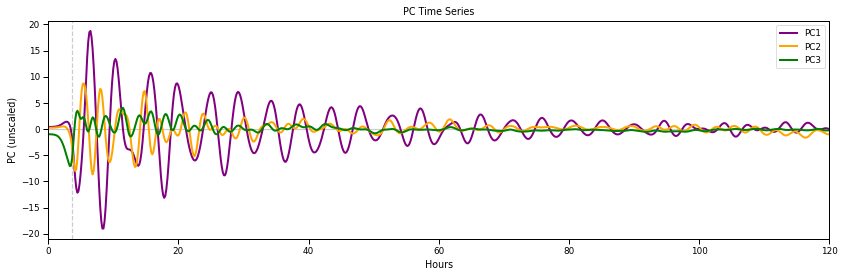

In [7]:
# Plot the leading PC time series.
sns.set_context('paper')
times = np.arange(0,720)*600
fig,ax = plt.subplots(1,1, figsize=(14,4))
ax.axhline(0, color='0.8')
ax.axvline(3.6, color='0.8', linestyle='--')
ax.plot(times/3600, pc[:,0], color='purple', linewidth=2, label='PC1')
ax.plot(times/3600, pc[:,1], color='orange', linewidth=2, label='PC2')
ax.plot(times/3600, pc[:,2], color='green', linewidth=2, label='PC3')
ax.set_title('PC Time Series')
ax.set_xlabel('Hours')
ax.set_ylabel('PC (unscaled)')
ax.set_xlim(0,120)
#plt.ylim(-3, 3)
plt.legend()
plt.show()

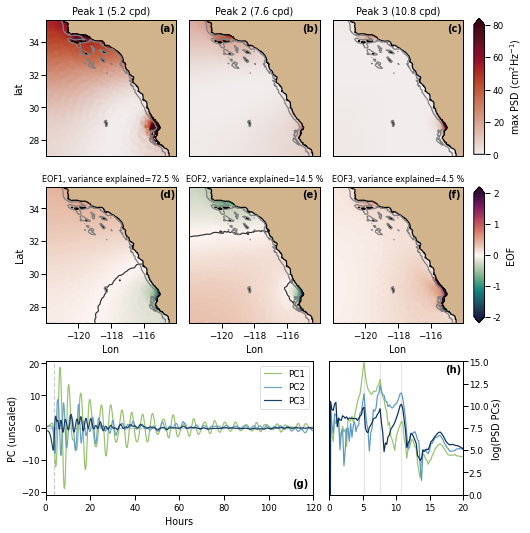

In [32]:
colors=("#d8d97a", "#95c36e", "#74c8c3", "#5a97c1", "#295384", "#0a2e57") # Hokusai 3 in MetBrewer
    
fig = plt.figure(figsize=(7.48,9))
gs0 = gridspec.GridSpec(2,1 ,height_ratios=[2,0.8], hspace=0.1 )
gs1 = gridspec.GridSpecFromSubplotSpec(2, 3, subplot_spec=gs0[0], wspace=0.1, hspace=0.0)
gs2 = gridspec.GridSpecFromSubplotSpec(1, 2, width_ratios=[1,0.5],wspace=0.08, subplot_spec=gs0[1])

ax1 = plt.subplot(gs1[1,0])
ax2 = plt.subplot(gs1[1,1])
ax3 = plt.subplot(gs1[1,2])
ax4 = plt.subplot(gs2[0])
ax8 = plt.subplot(gs2[1])
ax5 = plt.subplot(gs1[0,0])
ax6 = plt.subplot(gs1[0,1])
ax7 = plt.subplot(gs1[0,2])

ax1.set_ylabel('Lat')

## EOF's
for nmode, ax in zip([0,1,2], [ax1,ax2,ax3]):
    ax.set_facecolor('tan')
    cn = ax.pcolormesh(lons, lats, np.ma.masked_array(100*eof[nmode].squeeze(),mask=mask[0,:,:]), 
                       cmap=cmo.cm.curl, vmin=-2, vmax=2)   
    ax.contour(lons, lats, eof[nmode].squeeze(), levels=[0],colors=['0.2'])
    ax.contour(lons,lats, depth, levels=[0, 250], colors=['k','0.5'])
    ax.set_title(r'EOF%d, variance explained=%1.1f %%' %(nmode+1,100*(varFact[nmode])), fontsize=8)
    ax.set_aspect(1)
    ax.set_xlabel('Lon')

ax2.set_yticks([])
ax3.set_yticks([])
ax6.set_yticks([])
ax7.set_yticks([])
ax6.set_xticks([])
ax7.set_xticks([])
ax5.set_xticks([])

cbar_ax = fig.add_axes([0.92, 0.39, 0.02, 0.21]) 
cb = fig.colorbar(cn,cax=cbar_ax, orientation='vertical', 
                  format='%1.0f', label='EOF ($10^{-2}$ cm)', pad=0,
                  extend='both', ticks=[-2,-1,0,1,2])
cb.set_label('EOF')

# PCs
times = np.arange(0,720)*600
ax4.axhline(0, color='0.8')
ax4.axvline(3.6, color='0.8', linestyle='--')
ax4.plot(times/3600, pc[:,0], color=colors[1], label='PC1', alpha=1)
ax4.plot(times/3600, pc[:,1], color=colors[3], label='PC2', alpha=0.9)
ax4.plot(times/3600, pc[:,2], color=colors[5], label='PC3', alpha=0.9)
ax4.set_xlabel('Hours')
ax4.set_ylabel('PC (unscaled)')
ax4.set_xlim(0,120)
ax4.legend()

# PCs' spectra
ax8.axvline(5.2, color='0.5', alpha=0.2)
ax8.axvline(7.6, color='0.5', alpha=0.2)
ax8.axvline(10.8, color='0.5', alpha=0.2)

samp_freq = 1/600 # 10 min data
freq_per1, Pxx_den_per1 = signal.periodogram(pc[:,0], samp_freq, detrend='constant')
freq_per2, Pxx_den_per2 = signal.periodogram(pc[:,1], samp_freq, detrend='constant')
freq_per3, Pxx_den_per3 = signal.periodogram(pc[:,2], samp_freq, detrend='constant')

ax8.plot(freq_per1*(86400), np.log(Pxx_den_per1),'-',color=colors[1], alpha=1)  
ax8.plot(freq_per2*(86400), np.log(Pxx_den_per2),'-',color=colors[3], alpha=1)  
ax8.plot(freq_per3*(86400), np.log(Pxx_den_per3),'-',color=colors[5], alpha=1)  
ax8.set_xlim(0,20)
ax8.set_ylim(0,15)
ax8.yaxis.tick_right()
ax8.yaxis.set_label_position("right")
ax8.set_ylabel('log(PSD PCs)')

# - plot spatial structure of frequency peaks
ax5.set_facecolor('tan')
pc5 = ax5.pcolormesh(lons,lats, sshData.p1_psd, cmap=cmo.cm.amp, vmin=0, vmax=80)
levels=np.arange(0,80,10)
#cn5 = ax5.contour(lons,lats, sshData.p1_psd, levels, colors='1', alpha=0.5)
ax5.contour(lons,lats,depth,levels=[0, 250], colors=['k','0.5','0.5','0.5','0.5','0.5'])
ax5.set_ylabel('lat')
ax5.set_title('Peak 1 (5.2 cpd)')
ax5.set_aspect(1)

ax6.set_facecolor('tan')
pc6 = ax6.pcolormesh(lons,lats, sshData.p2_psd, cmap=cmo.cm.amp, vmin=0, vmax=80)
levels=np.arange(0,50,10)
#cn6 = ax6.contour(lons,lats, sshData.p2_psd, levels, colors='1', alpha=0.5)
ax6.contour(lons,lats,depth,levels=[0, 250], colors=['k','0.5','0.5','0.5','0.5','0.5'])
ax6.set_title('Peak 2 (7.6 cpd)')
ax6.set_aspect(1)

ax7.set_facecolor('tan')
pc7 = ax7.pcolormesh(lons,lats, sshData.p3_psd, cmap=cmo.cm.amp, vmin=0, vmax=80)
levels=np.arange(0,50,10)
#cn7 = ax7.contour(lons,lats, sshData.p3_psd, levels, colors='1', alpha=0.5)
ax7.contour(lons,lats,depth,levels=[0, 250], colors=['k','0.5','0.5','0.5','0.5','0.5'])
ax7.set_title('Peak 3 (10.8 cpd)')
ax7.set_aspect(1)

cbar_ax2 = fig.add_axes([0.92, 0.65, 0.02, 0.21]) 
cb2 = fig.colorbar(pc5,cax=cbar_ax2, orientation='vertical', 
                  format='%1.0f', label='max PSD (cm$^2$Hz$^{-1}$)', pad=0,
                  extend='max')

ax5.text(0.87,0.92,'(a)',fontweight='bold', fontsize=10, transform=ax5.transAxes)
ax6.text(0.87,0.92,'(b)',fontweight='bold', fontsize=10, transform=ax6.transAxes)
ax7.text(0.88,0.92,'(c)',fontweight='bold', fontsize=10, transform=ax7.transAxes)
ax1.text(0.87,0.92,'(d)',fontweight='bold', fontsize=10, transform=ax1.transAxes)
ax2.text(0.87,0.92,'(e)',fontweight='bold', fontsize=10, transform=ax2.transAxes)
ax3.text(0.88,0.92,'(f)',fontweight='bold', fontsize=10, transform=ax3.transAxes)
ax4.text(0.92,0.06,'(g)',fontweight='bold', fontsize=10, transform=ax4.transAxes)
ax8.text(0.87,0.92,'(h)',fontweight='bold', fontsize=10, transform=ax8.transAxes)

for ax in [ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8]:
    ax.tick_params(axis='y', which='major', pad=1)

plt.savefig('figure7.png', dpi=500, bbox_inches='tight')

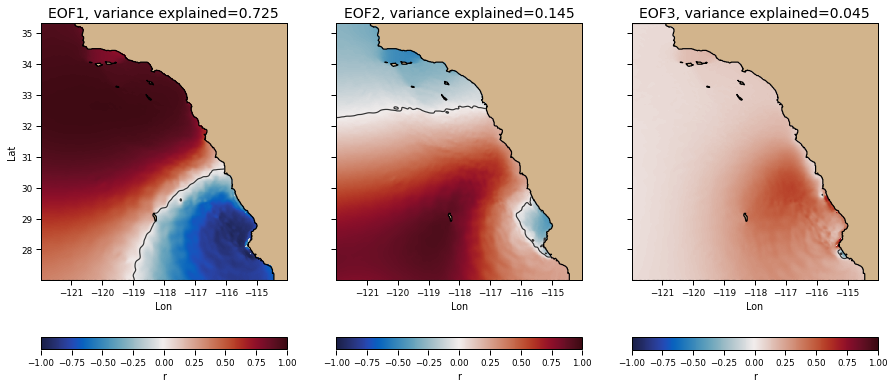

In [122]:
# Plot the leading EOF expressed as correlation in the Pacific domain.
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(15,7), sharey=True)
ax1.set_ylabel('Lat')
for nmode, ax in zip([0,1,2], [ax1,ax2,ax3]):
    ax.set_facecolor('tan')
    cn = ax.pcolormesh(lons, lats, np.ma.masked_array(eofCorr[nmode].squeeze(),mask=mask[0,:,:]), 
                       cmap=cmo.cm.balance, vmin=-1, vmax=1)
    cb = plt.colorbar(cn, ax=ax, orientation='horizontal', pad=0.15)
    ax.contour(lons, lats, eof[nmode].squeeze(), levels=[0],colors=['0.2'])
    ax.contour(lons,lats, depth, levels=[0], colors='k')
    cb.set_label('r')
    ax.set_title('EOF%d, variance explained=%1.3f' %(nmode+1,varFact[nmode]), fontsize=14)
    ax.set_aspect(1)
    ax.set_xlabel('Lon')